# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

In [5]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [6]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [7]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


There are 2435 whites and 2435 blacks.


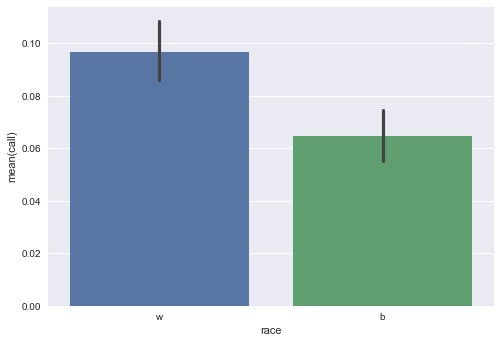

In [8]:
#Let's first keep only race and callbacks.
df = pd.DataFrame({'call':list(data.call),'race':list(data.race)})

#Now I can easily look at the relevant data for this exercise. 

white = df[df.race=='w']
black = df[df.race=='b']
print('There are {:1.0f} whites and {:1.0f} blacks.'.format(len(white),len(black)))

#Let's visually compare callbacks for both races:
import matplotlib.pyplot as plt
import seaborn as sns

_=sns.barplot(x='race',y='call',data=df)

plt.show()

In [9]:
#Proportions
def ratio_success(num,den):
    r= np.sum(num)/den
    return r

w_r=100*ratio_success(white.call,len(white.call))
b_r=100*ratio_success(black.call,len(black.call))

print('{:1.2f}% of the white-sounding got a call, while {:1.2f}% of the black-sounding got one.'.format(w_r,b_r))

#Now, for all callbacks:
w_c=100*ratio_success(white.call,np.sum(data.call))
b_c=100*ratio_success(black.call,np.sum(data.call))
print('{:1.2f}% of total callbacks for the white-sounding, while {:1.2f}% of total callbacks for the black-sounding.'.format(w_c,b_c))

9.65% of the white-sounding got a call, while 6.45% of the black-sounding got one.
59.95% of total callbacks for the white-sounding, while 40.05% of total callbacks for the black-sounding.


It looks like employers tend to call back more easily if the name is white-sounding.
<br>But let's set a test to confirm. We may use bootstrap pairs replicates with function = ratio_success and do a hypothesis test with H0: ratio of white_Callbacks per application = ratio of black_Callbacks per application.<br>
I don't know if this is the best and most straightforward solution, but it makes sense to me :).

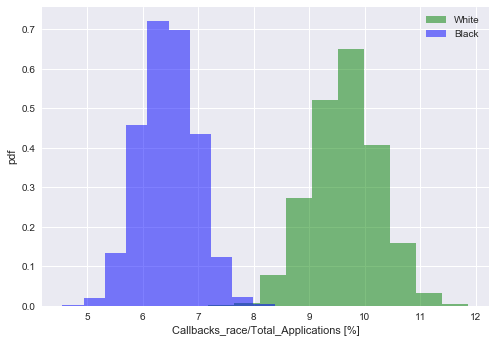

In [10]:
#1D bootstrap reps:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#Bootstrap replicates
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

#I need to tune my ratio func:
def ratio(data):
    r= np.sum(data)/len(data)
    return r

white_reps = draw_bs_reps(white.call,ratio,10000)
black_reps = draw_bs_reps(black.call,ratio,10000)

_=plt.hist(100*white_reps, bins=10, color = 'green', normed= True,label= 'White', alpha = 0.5)
_=plt.hist(100*black_reps, bins=10, color = 'blue', normed= True,label= 'Black', alpha = 0.5)
_=plt.xlabel('Callbacks_race/Total_Applications [%]')
_=plt.ylabel('pdf')
_=plt.legend(loc='upper right')
plt.show()

It is quite obvious that white-sounding names get more callbacks.
<br>
### 1 - What test is appropriate for this problem? Does CLT apply?
For CLT, we need normal distribution and independant observations. 
<br>We know there are independant. But whatabout normal distribution ?

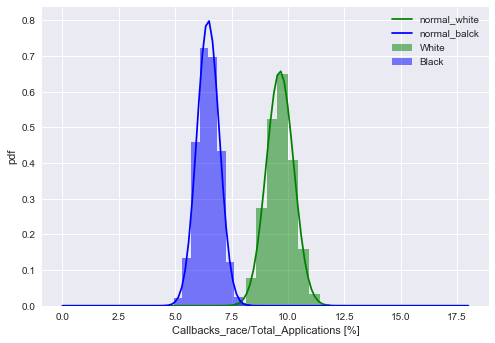

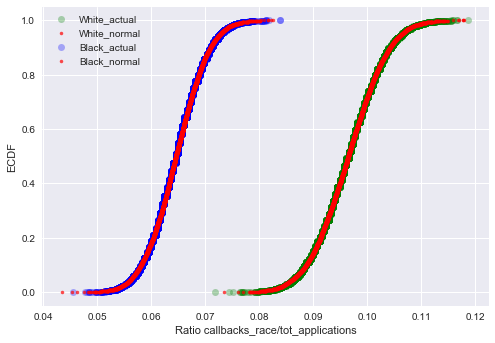

In [11]:
#ecdf function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,1+n) / n

    return x, y

#Let's plot ECDF of our data and of normally distributed data
central_w = np.random.normal(np.mean(white_reps),np.std(white_reps),len(white_reps))
central_b = np.random.normal(np.mean(black_reps),np.std(black_reps),len(black_reps))
x_w,y_w=ecdf(white_reps)
x_b,y_b=ecdf(black_reps)

x_central_w,y_central_w=ecdf(central_w)
x_central_b,y_central_b=ecdf(central_b)

x_norm = np.linspace(0, 18, 120)
pdf_w = stats.norm.pdf(x_norm, np.mean(100*white_reps), np.std(100*white_reps))
pdf_b = stats.norm.pdf(x_norm, np.mean(100*black_reps), np.std(100*black_reps))


#Pdf's
_=plt.hist(100*white_reps, bins=10, color = 'green', normed= True,label= 'White', alpha = 0.5)
_=plt.hist(100*black_reps, bins=10, color = 'blue', normed= True,label= 'Black', alpha = 0.5)
_=plt.plot(x_norm,pdf_w,color='green',label='normal_white')
_=plt.plot(x_norm,pdf_b,color='blue',label='normal_balck')

_=plt.xlabel('Callbacks_race/Total_Applications [%]')
_=plt.ylabel('pdf')
_=plt.legend(loc='upper right')

plt.show()
#ecdf's
_=plt.plot(x_w,y_w,marker='o',linestyle='none',color='green',alpha=0.3)
_=plt.plot(x_central_w,y_central_w,marker='.',linestyle='none',color='red',alpha=0.7)
_=plt.plot(x_b,y_b,marker='o',linestyle='none',color='blue',alpha=0.3)
_=plt.plot(x_central_b,y_central_b,marker='.',linestyle='none',color='red',alpha=0.7)
_=plt.xlabel('Ratio callbacks_race/tot_applications')
_=plt.ylabel('ECDF')
_=plt.legend(('White_actual','White_normal','Black_actual','Black_normal'))
plt.show()

CLT does apply !

### 2 - What are the null and alternate hypotheses?

The data is normally distributed as both graphs above show !
<br><br>
We do not know the stdev of the POPULATION --> Using z-score would not be correct. The t-test may therefore be more logical here. But with our sample size we can use both, it should be the same.
<br>H0: ratio of black callbacks per application = ratio of white callbacks per application
<br>H1: ratio of black callbacks per application < ratio of white callbacks per application

<br>It's the same to say:<br>
H0: difference of ratios is equal to zero
<br>H1: difference of ratios (white-black) is > 0
<br>Let's have a look. We'll take a significance level of 95% (p-value < 0,05 to reject null hypothesis)

### 3 - Compute margin of error, confidence interval, and p-value.

In [22]:
from scipy import stats
from statsmodels.stats.weightstats import ztest
import statsmodels.stats.api as sms

t_score, pValue_t = stats.ttest_ind(white_reps,black_reps, axis=0)
print('t_score is {:1.8f}, p-value is {:1.12f}'.format(t_score,pValue_t))

z_score, pValue_z = ztest(x1= white_reps, x2=black_reps, alternative='two-sided', usevar='pooled', ddof=1)
print('z_score is {:1.8f}, p-value is {:1.12f}'.format(z_score,pValue_z))

t_score is 406.24662733, p-value is 0.000000000000
z_score is 406.24662733, p-value is 0.000000000000


It is highly significant that there is a difference in white callbacks ratio and black callbacks ratio, which cannot be due to hazard. White-sounding name have significantly more chances to get a callback than black-sounding names.

Let's do the test with our callbacks only (not the ratios from bootstrap samples=bootstrap replicates):

In [24]:
t_score, pValue_t = stats.ttest_ind(white.call,black.call, axis=0)
print('t_score is {:1.8f}, p-value is {:1.12f}'.format(t_score,pValue_t))

z_score, pValue_z = ztest(x1= white.call, x2=black.call, alternative='two-sided', usevar='pooled', ddof=1)
print('z_score is {:1.8f}, p-value is {:1.12f}'.format(z_score,pValue_z))

t_score is 4.11470527, p-value is 0.000039408025
z_score is 4.11470527, p-value is 0.000038767444


In [34]:
#Margin of error (moe) and confidence interval (CI) for 95%:

#FOR WHITE CALLBACKS RATIO
interval_w = stats.norm.interval(0.95, loc=np.mean(100*white_reps), scale=(np.std(100*white_reps)/np.sqrt(len(white_reps))))
print('Interval of confidence (95%) for white callback ratio is : ', interval_w,' %')

#We use std/sqrt(n) because of n observations in sample. See : http://napitupulu-jon.appspot.com/posts/confidence-interval-coursera-statistics.html

#or 95% CI is also mean +/- 1.96*stdev
low = np.mean(100*white_reps)-1.96*(np.std(100*white_reps)/np.sqrt(len(white_reps)))
high=np.mean(100*white_reps)+1.96*(np.std(100*white_reps)/np.sqrt(len(white_reps)))
print('verification : ', low,high)
#Ok it's the same

#Margin of error ME is half of interval:
moe_w = 0.5*(interval_w[1]-interval_w[0])
print('Margin of error white callbacks ratio = ',moe_w)

#FOR BLACK CALLBACKS RATIO
interval_w = stats.norm.interval(0.95, loc=np.mean(100*black_reps), scale=(np.std(100*black_reps)/np.sqrt(len(black_reps))))
print('Interval of confidence (95%) for black callback ratio is : ', interval_w,' %')

#We use std/sqrt(n) because of n observations in sample. See : http://napitupulu-jon.appspot.com/posts/confidence-interval-coursera-statistics.html

#or 95% CI is also mean +/- 1.96*stdev
low = np.mean(100*black_reps)-1.96*(np.std(100*black_reps)/np.sqrt(len(black_reps)))
high=np.mean(100*black_reps)+1.96*(np.std(100*black_reps)/np.sqrt(len(black_reps)))
print('verification : ', low,high)
#Ok it's the same

#Margin of error ME is half of interval:
moe_w = 0.5*(interval_w[1]-interval_w[0])
print('Margin of error black callbacks ratio = ',moe_w, ' %')

Interval of confidence (95%) for white callback ratio is :  (9.6335122693013968, 9.6572803385014776)  %
verification :  9.63351205093 9.65728055688
Margin of error white callbacks ratio =  0.0118840346
Interval of confidence (95%) for black callback ratio is :  (6.4481548747000508, 6.4676726407003597)  %
verification :  6.44815469537 6.46767282003
Margin of error black callbacks ratio =  0.00975888300015  %


Interval is wider for white callbacks.
### 4 - Write a story describing the statistical significance in the context or the original problem.

Here above, I tried to look at the data and perform a few tests on it in a way that makes sense to me. <br>
I decided to look at the ratio of callbacks compared to total amount of CV sent for white and black sounding names. 
I could only perform the ratio on the one sample I had for each race. I decided to create some more samples using bootstrap. <br>Then, I could compute way more ratios (same distribution, which is normal as I could see). Plotting distribution of ratios, it was clear that there was a significant difference based on race ! But I still needed to test this.
<br>The two samples t-test gave me comforting results with a very low p-value (0). This means there is no chance that I could get these results by chance. The null hypothesis could therefore be rejected (H0 = no difference in ratio). The difference is sgnificant ! 
<br>In the end, it sadly means that you may find it easier to get a job with a white-sounding name, as people tend to call back more easily if you have one.

### 5 - Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Not at all ! It only means that race/name has a significant impact on whether you may get a call back. But it has not been compared to the other parameters.
<br> We could look at the impact of all features on callback success/fail.